<div style="display: flex; align-items: center;">
    <div style="display: flex; flex-direction: column; align-items: center;">
        <h1 style="text-align: right;">Centro de Investigación en Matemáticas, A.C.</h1>
        <h2 style="text-align: right;">Reconocimiento de Patrones</h2>
        <h3 style="text-align: right;">Proyecto</h3>
    </div>
    <img src="Figures\logoCIMAT11.png" alt="CIMAT Logo" width="200" style="float: left;">
</div>


---

### Arturo Sair García Amador
### Jose Miguel Saavedra Aguilar


Este archivo solo es como referencia de los códigos utilizados en el reporte PDF

In [1]:
import numpy as np  # Importing NumPy for numerical operations and array handling.
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations.
import pandas as pd  # Importing Pandas for data manipulation and analysis.
import random  # Importing the random module for generating random numbers or selecting items at random.
import seaborn as sns  # Importing Seaborn for statistical data visualization based on Matplotlib.
from sklearn.preprocessing import StandardScaler  # Importing StandardScaler from scikit-learn to standardize features by removing the mean and scaling to unit variance.
from sklearn.decomposition import PCA  # Importing Principal Component Analysis (PCA) from scikit-learn for dimensionality reduction techniques.
import statsmodels.api as sm  # Importing StatsModels API for various statistical models, tests, and data exploration tools.
from sklearn.metrics import r2_score, mean_squared_error  # Importing metrics from scikit-learn to evaluate the performance of regression models.

np.random.seed(2025)  # Setting a seed for NumPy's random number generator to ensure reproducibility of results.


In [2]:
# Load the dataset from a CSV file into a pandas DataFrame named 'est'
est = pd.read_csv('disponibilidad_estacionamientos_final.csv')

# Load a CSV file containing the maximum capacity data into a pandas DataFrame named 'MaxEst'
MaxEst = pd.read_csv('MaxEst.csv')

# Drop any rows with missing values (NaNs) in the 'est' DataFrame to ensure data quality
est = est.dropna()

# Retrieve all column names starting from the second column, as those are the parking lot names
column_names = est.columns.tolist()[1:]

# Convert the 'Fecha_Hora' column of the 'est' DataFrame into datetime objects for time series analysis
est['Fecha_Hora'] = pd.to_datetime(est['Fecha_Hora'])

# Calculate a ratio between available spaces and maximum capacity, ensuring no negative values using np.maximum
est_ratio = np.maximum(1 - est[column_names].div(MaxEst[column_names].values,
                                                  axis=1),0)

# Convert the 'Fecha_Hora' column to a Unix timestamp (seconds since epoch) and divide by 3600*24 to convert to days
est_ratio['Date_Time'] = est['Fecha_Hora'].apply(lambda x: pd.to_datetime(x).
                                                 timestamp()/(3600*24))

# Extract weekday information from 'Fecha_Hora', where Monday is represented as 0, ..., Sunday as 6
est_ratio['Weekday'] = est['Fecha_Hora'].dt.weekday

# Compute the time component (fractional day) from the 'Date_Time' column by subtracting the floor value of it
est_ratio['Time'] = (est_ratio['Date_Time'] - np.floor(est_ratio['Date_Time']))

In [3]:
# Cyclic encoding for 'Weekday' using sine and cosine transformations.
# This helps to preserve the cyclic nature of hours (e.g., 00:00 follows 23:59).

est_ratio['Time_sin'] = np.sin(2 * np.pi * est_ratio['Time'])
est_ratio['Time_cos'] = np.cos(2 * np.pi * est_ratio['Time'])

# Set starting time as 0
est_ratio['Date_Time'] = est_ratio['Date_Time'] - est_ratio['Date_Time'][0]

In [4]:
# Cyclic encoding for 'Weekday' using sine and cosine transformations.
# This helps to preserve the cyclic nature of weekdays (e.g., Monday follows Sunday).
est_ratio['Weekday_sin'] = np.sin(2 * np.pi * est_ratio['Weekday'] / 7)
est_ratio['Weekday_cos'] = np.cos(2 * np.pi * est_ratio['Weekday'] / 7)

# Drop the original 'Weekday' and 'Time' columns
est_ratio.drop(columns=['Time','Weekday'], inplace=True)

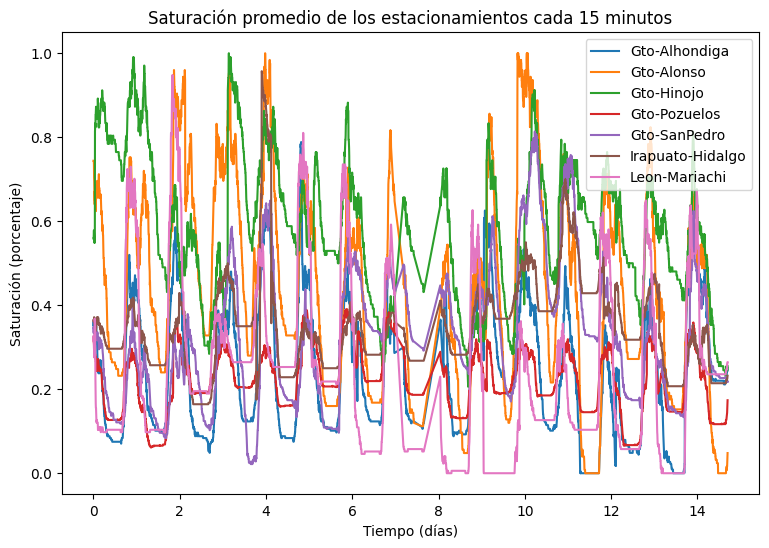

In [5]:
# Create a plot of the saturation of parking lots over time.
plt.figure(figsize=(9,6))
for col in column_names:
    # Plot each column of data against the 'Date_Time' axis
    plt.plot(est_ratio['Date_Time'], est_ratio[col], label=col)

# Set title and labels
plt.title('Saturación promedio de los estacionamientos cada 15 minutos')
plt.xlabel('Tiempo (días)')
plt.ylabel('Saturación (porcentaje)')

# Add legend to differentiate between columns
plt.legend()

# Display the plot
plt.show()

In [6]:
# Melt the 'est_ratio' DataFrame to transform it from wide format to long format.
# Retain specific columns: 'Date_Time', 'Time_sin', 'Time_cos', 'Weekday_sin', and 'Weekday_cos'.
# Use 'Parking_Lot' as the variable name for the new column that will hold the names of the original columns.
# Assign 'Saturation' as the value name for the values in the melted DataFrame.

est_long = est_ratio.melt(
    id_vars=['Date_Time', 'Time_sin', 'Time_cos', 'Weekday_sin', 'Weekday_cos'],  # Columns to keep aside from the variable being unpivoted
    var_name='Parking_Lot',  # Name for the column containing names of original columns
    value_name='Saturation'   # Name for the column containing values from the melted DataFrame
)

# Drop the 'Date_Time' column as it is no longer needed in the resulting long-format DataFrame.
est_long.drop(columns=['Date_Time'], inplace=True)

In [7]:
# Scale the data to have zero mean and unit variance, excluding 'Date_Time' column
scaler = StandardScaler()
est_scaled = scaler.fit_transform(est_ratio.drop(columns=['Date_Time']))

# Perform Principal Component Analysis (PCA) to reduce data to 2 dimensions
pca = PCA(n_components=2)
pca_data = pca.fit_transform(est_scaled)


In [8]:
def myplot(score,coeff,var_labels=None, points_labels=None):
    # xs and ys are the first two principal components of the score matrix
    xs = score[:,0]
    ys = score[:,1]

    # n is the number of variables in the original data set
    n = coeff.shape[0]

    # scalex and scaley are used to normalize the scores so they fit within a unit square for plotting
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    # Initialize the figure
    plt.figure(figsize=(9, 6))

    # If no points_labels are provided, scatter plot all the scores using different colors
    if points_labels is None:
        plt.scatter(xs * scalex, ys * scaley, cmap='rainbow', s = 1, alpha = 0.2)
    else:
        # If points_labels are provided, scatter plot the scores using different colors based on their labels
        plt.scatter(xs * scalex, ys * scaley, c=points_labels, cmap='rainbow', s = 1, alpha = 0.2)


    # Loop through each variable in the original data set and draw an arrow pointing to its corresponding principal component
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r',alpha = 0.5)

        # If no var_labels are provided, label each principal component with the variable it corresponds to
        if var_labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            # If var_labels are provided, label each principal component with the variable name
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, var_labels[i], color = 'g', ha = 'center', va = 'center')

    # Set the x and y limits of the plot to be within a unit square for better visualization
    plt.xlim(-1,1)
    plt.ylim(-1,1)

    # Label the axes with "PC{}".format(1) and "PC{}".format(2)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))

    # Show a grid on the plot for better readability
    plt.grid()

C:\Users\micke\AppData\Local\Temp\ipykernel_25916\337598836.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xs * scalex, ys * scaley, cmap='rainbow', s = 1, alpha = 0.2)


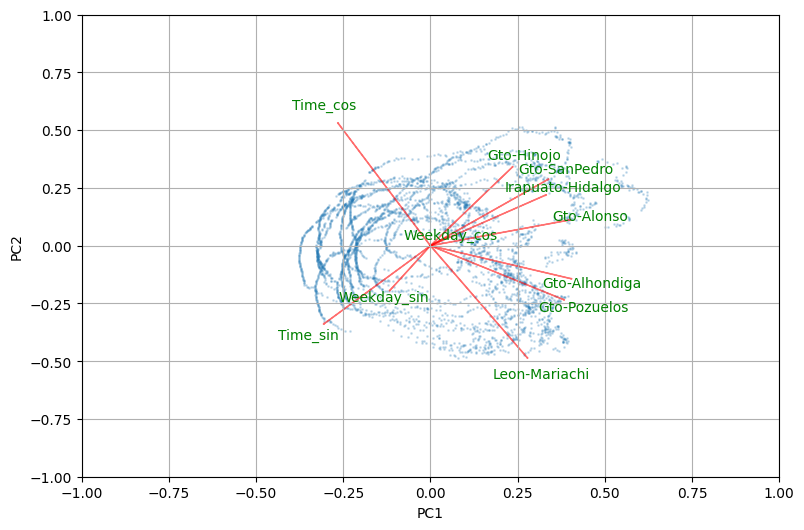

In [9]:
myplot(pca_data[:,0:2], np.transpose(pca.components_[0:2, :]), var_labels = est_ratio.drop(columns=['Date_Time']).columns.values)

In [10]:
# Convert 'est_long' DataFrame to a new DataFrame with dummy variables for 'Parking_Lot'
est_tagged = pd.get_dummies(est_long, columns=['Parking_Lot'], dtype = int)

# Define the parking lots that should be labeled as "center"
center_lots = ['Gto-Alonso', 'Gto-Hinojo', 'Gto-SanPedro']

# Create a new variable 'est_center' that is 1 if the  'Parking_Lot' is in 'center_lots'
est_center = est_long['Parking_Lot'].isin(center_lots).astype(int)

# Create the 'center_Time_sin' and 'center_Time_cos' columns in est_tagged
est_tagged['center_Time_sin'] = est_center * est_tagged['Time_sin']
est_tagged['center_Time_cos'] = est_center * est_tagged['Time_cos']

# Create the 'other_Time_sin' and 'other_Time_cos' columns in est_tagged
est_tagged['other_Time_sin'] = (1 - est_center) * est_tagged['Time_sin']
est_tagged['other_Time_cos'] = (1 - est_center) * est_tagged['Time_cos']

# Drop the 'Time_sin' and 'Time_cos' columns from est_tagged, as they are no longer needed

est_tagged.drop(columns=['Time_sin','Time_cos'], inplace=True)

In [11]:
# Prepare the independent variables (all other columns except 'Saturation')
independent_vars = est_tagged.drop(columns=['Saturation'])

# Prepare the dependent variable ('Saturation')
dependent_var = est_tagged['Saturation']

# Initialize and fit an OLS model
linear_model = sm.OLS(dependent_var, independent_vars)
linear_result = linear_model.fit()

# Display model summary
print(linear_result.summary())
print("R² Score:", r2_score(dependent_var, linear_result.predict(independent_vars)))
print("Mean Squared Error:", mean_squared_error(dependent_var, linear_result.predict(independent_vars)))

                            OLS Regression Results                            
Dep. Variable:             Saturation   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     3578.
Date:                Tue, 08 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:09:02   Log-Likelihood:                 17097.
No. Observations:               28497   AIC:                        -3.417e+04
Df Residuals:                   28484   BIC:                        -3.406e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Weekday_sin     

In [12]:
# Define the radians to day hours conversion factor r as pi divided by 12.
r = np.pi / 12

# Create an array of integers from 0 to 23 representing times in hours over a day.
times = np.arange(24)

# Construct a matrix Times with two columns:
# one for sine and another for cosine transformations
# of the 'times' array, scaled by r.
Times = np.column_stack((np.sin(r * times), np.cos(r * times)))

# Create an array where each row represents the sine and cosine values
# corresponding to each hour of a day for
# both center and other parking lots.
center_Time_coefficients = np.array(linear_result.params[
    ['center_Time_sin', 'center_Time_cos']])
other_Time_coefficients = np.array(linear_result.params[
    ['other_Time_sin', 'other_Time_cos']])

# Multiply the Times matrix by the Times_coefficients vector to get the
# linear combination representing the weekly pattern for
# both center and other parking lots.
center_time_coeff = Times @ center_Time_coefficients
other_time_coeff = Times @ other_Time_coefficients

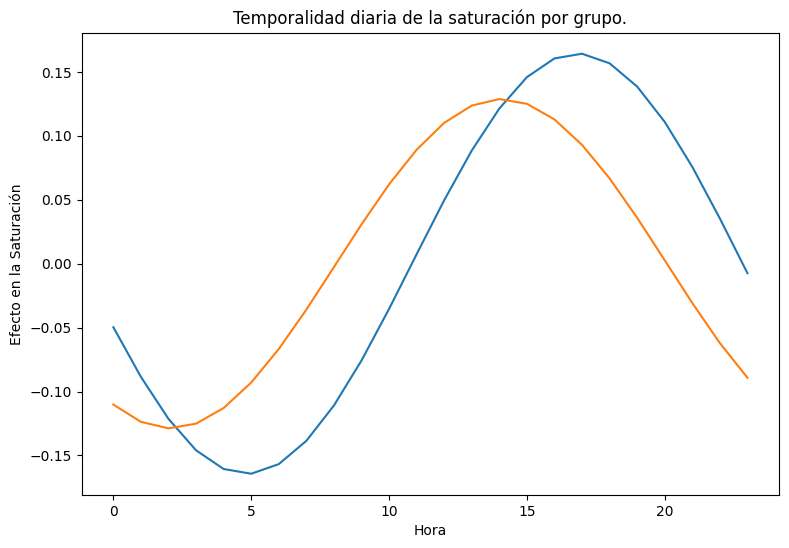

In [13]:
# Set the size of the figure for better readability and clarity in presentation
plt.figure(figsize=(9, 6))

# Plot 'center_time_coeff' against 'times'
plt.plot(times, center_time_coeff)

# Plot 'other_time_coeff' against 'times'
plt.plot(times, other_time_coeff)

# Add labels and title for better understanding of the plot
plt.xlabel('Hora')
plt.ylabel('Efecto en la Saturación')
plt.title('Temporalidad diaria de la saturación por grupo.')
plt.show()


In [14]:
# Extract coefficients related to weekdays from a linear regression result object.
Day_coefficients = np.array(linear_result.params[['Weekday_sin', 'Weekday_cos']])

# Define the number of days in a week, i.e., 0 (Sunday) through 6 (Saturday).
days = np.arange(7)

# Calculate radians to days of a week conversion rate.
r = np.pi * 2 / 7

# Create an array where each row represents the sine and cosine values
# corresponding to each day of the week.
Days = np.column_stack((np.sin(r * days), np.cos(r * days)))

# Multiply the Days matrix by the Day_coefficients vector to get the
# linear combination representing the weekly pattern.

day_coeff = Days @ Day_coefficients


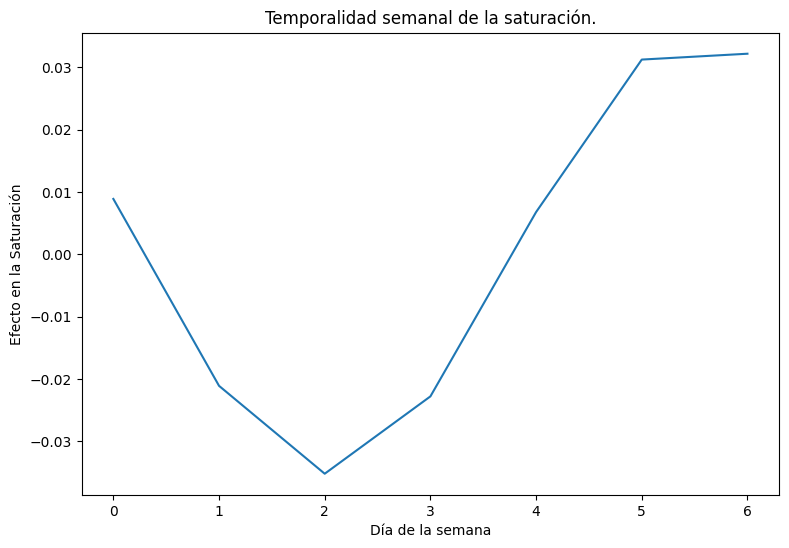

In [15]:
# Set the size of the figure for better readability and clarity in presentation
plt.figure(figsize=(9, 6))

# Plot 'day_coeff' against 'days'
plt.plot(days, day_coeff)

# Add labels and title for better understanding of the plot
plt.xlabel('Día de la semana')
plt.ylabel('Efecto en la Saturación')
plt.title('Temporalidad semanal de la saturación.')
plt.show()

In [16]:
# Create an empty dictionary to store percentage values above threshold for each column
percentage_above_threshold = {}

# Iterate through each column name in the list of columns
for col in column_names:
    # Calculate the mean percentage of values greater than 0.8 (80%) in the 'est_ratio' DataFrame for the current column
    percentage = (est_ratio[col] > 0.8).mean() * 100

    # Store the calculated percentage value in the dictionary with the column name as the key
    percentage_above_threshold[col] = percentage

# The resulting dictionary now contains the percentage of values above threshold for each column
percentage_above_threshold

{'Gto-Alhondiga': np.float64(0.0),
 'Gto-Alonso': np.float64(8.892164087447801),
 'Gto-Hinojo': np.float64(11.127487103905674),
 'Gto-Pozuelos': np.float64(0.0),
 'Gto-SanPedro': np.float64(0.17194792434291328),
 'Irapuato-Hidalgo': np.float64(1.3264554163596167),
 'Leon-Mariachi': np.float64(1.007123556865635)}